# Uncertainty as a function of training epoch
Looking at both DER and DE models.

In [1]:
from scripts import train, models, analysis, io
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)
DEVICE = get_best_device()

In [31]:
def load_model_checkpoint(model, model_name, epoch, device, path='../models'):
    """
    Load PyTorch model checkpoint from a .pt file.

    :param path: Location to load the model from
    :param DER_type: Type of your model
    :param epoch: Epoch to load
    :param device: Device to load the model onto ('cuda' or 'cpu')
    :param model: PyTorch model to load the checkpoint into
    :return: Loaded model
    """
    file_name = f"{path}/{model_name}_epoch_{epoch}.pt"
    
    checkpoint = torch.load(file_name, map_location=device)
    return checkpoint

def load_loss_DER(checkpoint):
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    # Extract additional information
    loaded_epoch = checkpoint.get('epoch', None)
    train_loss = checkpoint.get('train_loss', None)
    valid_loss = checkpoint.get('valid_loss', None)
    mse_valid_loss = checkpoint.get('valid_mse', None)
    return loaded_epoch, train_loss, valid_loss, mse_valid_loss


def ep_al_checkpoint_DER(checkpoint):    
    # Handle the case where extra information is present in the state_dict
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    # Extract additional information
    loaded_epoch = checkpoint.get('epoch', None)
    med_u_ep_validation = checkpoint.get('med_u_ep_validation', None)
    med_u_al_validation = checkpoint.get('med_u_al_validation', None)
    std_u_ep_validation = checkpoint.get('std_u_ep_validation', None)
    std_u_al_validation = checkpoint.get('std_u_al_validation', None)

    return model, loaded_epoch,\
        med_u_ep_validation, med_u_al_validation,\
        std_u_ep_validation, std_u_al_validation

def ep_al_checkpoint_DE(checkpoint):    
    # Handle the case where extra information is present in the state_dict
    '''
    if 'model_state_dict' in checkpoint:
        try:
            model.load_state_dict(checkpoint['model_state_dict'])
        except RuntimeError:
            print('cannot load via state dict')
            #print('checkpoint', checkpoint)
            #print('attempting to load', model.load_state_dict(checkpoint))
            #model.load_state_dict(checkpoint)
    else:
        model.load_state_dict(checkpoint)
    '''

    # Extract additional information
    loaded_epoch = checkpoint.get('epoch', None)
    mean_validation = checkpoint.get('valid_mean', None)
    sigma_validation = checkpoint.get('valid_sigma', None)

    
    return model, loaded_epoch, mean_validation, sigma_validation

First, initialize the model.

In [15]:
DER_type = 'DER'
model, _ = models.model_setup_DER(DER_type, DEVICE)

ep_high = []
al_high = []
ep_medium = []
al_medium = []
ep_low = []
al_low = []

ep_std_high = []
al_std_high = []
ep_std_medium = []
al_std_medium = []
ep_std_low = []
al_std_low = []

train_loss_high = []
valid_loss_high = []
mse_valid_loss_high = []
train_loss_medium = []
valid_loss_medium = []
mse_valid_loss_medium = []
train_loss_low = []
valid_loss_low = []
mse_valid_loss_low = []

n_epochs = 100
for e in range(n_epochs):
    chk = load_model_checkpoint(model, DER_type+'_noise_high', e, DEVICE)
    _, _, epistemic_h, aleatoric_h, e_std, a_std = ep_al_checkpoint_DER(chk)
    ep_high.append(epistemic_h)
    al_high.append(aleatoric_h)
    ep_std_high.append(e_std)
    al_std_high.append(a_std)
    # also get losses
    _, train_loss, valid_loss, mse_valid_loss = load_loss_DER(chk)
    train_loss_high.append(train_loss)
    valid_loss_high.append(valid_loss)
    mse_valid_loss_high.append(mse_valid_loss)
    
    chk = load_model_checkpoint(model, DER_type+'_noise_medium', e, DEVICE)
    _, _, epistemic_m, aleatoric_m, e_std, a_std = ep_al_checkpoint_DER(chk)
    ep_medium.append(epistemic_m)
    al_medium.append(aleatoric_m)
    ep_std_medium.append(e_std)
    al_std_medium.append(a_std)
    _, train_loss, valid_loss, mse_valid_loss = load_loss_DER(chk)
    train_loss_medium.append(train_loss)
    valid_loss_medium.append(valid_loss)
    mse_valid_loss_medium.append(mse_valid_loss)
    
    chk = load_model_checkpoint(model, DER_type+'_noise_low', e, DEVICE)
    _, _, epistemic_l, aleatoric_l, e_std, a_std = ep_al_checkpoint_DER(chk)
    ep_low.append(epistemic_l)
    al_low.append(aleatoric_l)
    ep_std_low.append(e_std)
    al_std_low.append(a_std)
    _, train_loss, valid_loss, mse_valid_loss = load_loss_DER(chk)
    train_loss_low.append(train_loss)
    valid_loss_low.append(valid_loss)
    mse_valid_loss_low.append(mse_valid_loss)

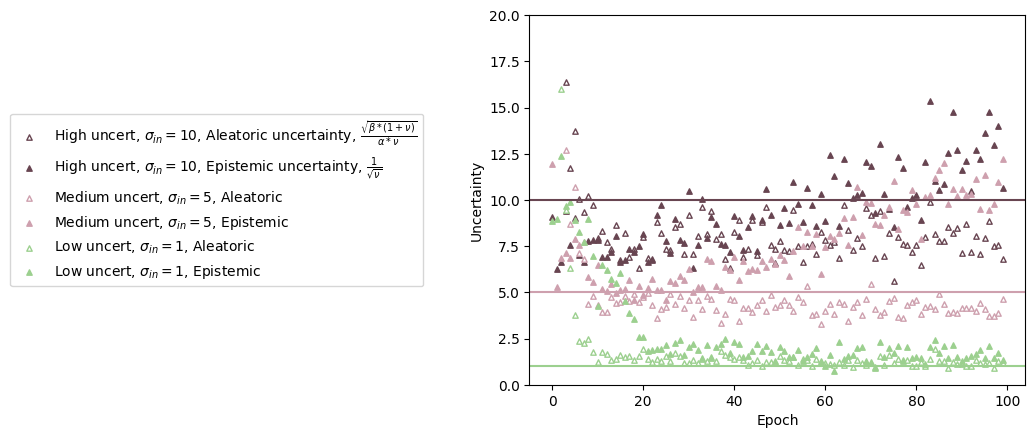

In [23]:
# overplot both
ptsize = 15
plt.clf()
plt.scatter(range(n_epochs), al_high,
            edgecolor = '#684551',
            color = 'white',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plt.scatter(range(n_epochs), ep_high,
            color = '#684551',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')
plt.axhline(y = 10,
            color = '#684551')

plt.scatter(range(n_epochs), al_medium,
            edgecolor = '#CEA0AE',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Aleatoric')
plt.scatter(range(n_epochs), ep_medium,
            color = '#CEA0AE',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Epistemic')
plt.axhline(y = 5,
            color = '#CEA0AE')
plt.scatter(range(n_epochs), al_low,
            edgecolor = '#9CD08F',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Aleatoric')
plt.scatter(range(n_epochs), ep_low,
            color = '#9CD08F',
            marker = '^',
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Epistemic')
plt.axhline(y = 1,
            color = '#9CD08F')
# total = sqrt(ep^2 + al^2)
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Uncertainty')
plt.xlabel('Epoch')
plt.ylim([0,20])

#plt.show()
plt.savefig(DER_type+'_ep_al_by_epoch.png')


In [ ]:
# overplot both
ptsize = 25
plt.clf()
plt.scatter(range(n_epochs), al_high,
            color = '#1F7A8C',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plus = np.array(al_high) + np.array(al_std_high)
minus = np.array(al_high) - np.array(al_std_high)
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#1F7A8C',
                 alpha = 0.5)
plt.scatter(range(n_epochs), ep_high,
            color = '#EFB0A1',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')
plus = np.array(ep_high) + np.array(ep_std_high)
minus = np.array(ep_high) - np.array(ep_std_high)
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#EFB0A1',
                 alpha = 0.5)

plt.axhline(y = 10, color = 'black')
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Uncertainty')
plt.xlabel('Epoch')
plt.ylim([0,40])
plt.show()


In [ ]:

plt.clf()
plt.scatter(range(n_epochs), al_medium,
            color = '#1F7A8C',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 10$, Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plus = np.array(al_medium) + np.array(al_std_medium)
minus = np.array(al_medium) - np.array(al_std_medium)
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#1F7A8C',
                 alpha = 0.5)
plt.scatter(range(n_epochs), ep_medium,
            color = '#EFB0A1',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')
plus = np.array(ep_medium) + np.array(ep_std_medium)
minus = np.array(ep_medium) - np.array(ep_std_medium)
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#EFB0A1',
                 alpha = 0.5)

plt.axhline(y = 5, color = 'black')
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Uncertainty')
plt.xlabel('Epoch')
plt.ylim([0,40])
plt.show()

plt.clf()
plt.scatter(range(n_epochs), al_low,
            color = '#1F7A8C',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 1$, Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plus = np.array(al_low) + np.array(al_std_low)
minus = np.array(al_low) - np.array(al_std_low)
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#1F7A8C',
                 alpha = 0.5)
plt.scatter(range(n_epochs), ep_low,
            color = '#EFB0A1',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 1$, Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')
plus = np.array(ep_low) + np.array(ep_std_low)
minus = np.array(ep_low) - np.array(ep_std_low)
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#EFB0A1',
                 alpha = 0.5)

plt.axhline(y = 1, color = 'black')
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Uncertainty')
plt.xlabel('Epoch')
plt.ylim([0,40])
plt.show()

## Lets also look at the loss plots for DER


In [ ]:
# overplot both
ptsize = 15
plt.clf()
plt.scatter(range(n_epochs), train_loss_high,
            edgecolor = '#684551',
            color = 'white',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Training loss')
plt.scatter(range(n_epochs), valid_loss_high,
            color = '#684551',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Validation loss')
#plt.axhline(y = 10,
#            color = '#684551')

plt.scatter(range(n_epochs), train_loss_medium,
            edgecolor = '#CEA0AE',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Training loss')
plt.scatter(range(n_epochs), valid_loss_medium,
            color = '#CEA0AE',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Validation loss')
#plt.axhline(y = 5,
#            color = '#CEA0AE')
plt.scatter(range(n_epochs), train_loss_low,
            edgecolor = '#9CD08F',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Training loss')
plt.scatter(range(n_epochs), valid_loss_low,
            color = '#9CD08F',
            marker = '^',
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Validation loss')
#plt.axhline(y = 1,
#            color = '#9CD08F')
# total = sqrt(ep^2 + al^2)
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,15])

plt.show()
#plt.savefig('DER_train_valid_loss.png')

# interesting it really decreases slowly

## MSE loss versus NIG loss

In [ ]:
# overplot both
ptsize = 15
plt.clf()
plt.scatter(range(n_epochs), mse_valid_loss_high,
            edgecolor = '#684551',
            color = 'white',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, MSE Validation loss')
plt.scatter(range(n_epochs), valid_loss_high,
            color = '#684551',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Validation loss')
#plt.axhline(y = 10,
#            color = '#684551')

plt.scatter(range(n_epochs), mse_valid_loss_medium,
            edgecolor = '#CEA0AE',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, MSE Validation loss')
plt.scatter(range(n_epochs), valid_loss_medium,
            color = '#CEA0AE',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Validation loss')
#plt.axhline(y = 5,
#            color = '#CEA0AE')
plt.scatter(range(n_epochs), mse_valid_loss_low,
            edgecolor = '#9CD08F',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, MSE Validation loss')
plt.scatter(range(n_epochs), valid_loss_low,
            color = '#9CD08F',
            marker = '^',
            s = ptsize,
            label = r'Low uncert, $\sigma_{in} = 1$, Validation loss')
#plt.axhline(y = 1,
#            color = '#9CD08F')
# total = sqrt(ep^2 + al^2)
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,500])

plt.show()
#plt.savefig('DER_valid_loss_with_MSE.png')

# looks like MSE does not decrease at the same rate as the loss from NIG

## Now look at this for the deep ensemble models
This is a little trickier because you need to look at multiple models simultaneously.

In [32]:
nmodels = 20
nepochs = 100
DE_type = 'bnll_loss'
model, mse_loss_de = models.model_setup_DE(DE_type, DEVICE)

In [33]:
low_ep = []
low_al_var = []
low_ep_std = []
low_al_var_std = []
for e in range(nepochs):
    list_mus = []
    list_sigs = []
    for n in range(nmodels):

        model_name = 'DE_noise_low_nmodel_' + str(n)
        chk = load_model_checkpoint(model, model_name, e, DEVICE)
        _, _, mu_vals, sig_vals = ep_al_checkpoint_DE(chk)
        list_mus.append(mu_vals.detach().numpy())
        list_sigs.append(sig_vals.detach().numpy()**2)
    low_ep.append(np.median(np.std(list_mus, axis = 0)))
    low_al_var.append(np.median(np.mean(list_sigs, axis = 0)))
    low_ep_std.append(np.std(np.std(list_mus, axis = 0)))
    low_al_var_std.append(np.std(np.mean(list_sigs, axis = 0)))
med_ep = []
med_al_var = []
med_ep_std = []
med_al_var_std = []
for e in range(nepochs):
    list_mus = []
    list_sigs = []
    for n in range(nmodels):
    
        model_name = 'DE_noise_medium_nmodel_' + str(n)
        chk = load_model_checkpoint(model, model_name, e, DEVICE)
        _, _, mu_vals, sig_vals = ep_al_checkpoint_DE(chk)
        list_mus.append(mu_vals.detach().numpy())
        list_sigs.append(sig_vals.detach().numpy()**2)
    med_ep.append(np.median(np.std(list_mus, axis = 0)))
    med_al_var.append(np.median(np.mean(list_sigs, axis = 0)))
    med_ep_std.append(np.std(np.std(list_mus, axis = 0)))
    med_al_var_std.append(np.std(np.mean(list_sigs, axis = 0)))

high_ep = []
high_al_var = []
high_ep_std = []
high_al_var_std = []
for e in range(nepochs):
    list_mus = []
    list_sigs = []
    for n in range(nmodels):
    
        model_name = 'DE_noise_high_nmodel_' + str(n)
        chk = load_model_checkpoint(model, model_name, e, DEVICE)
        _, _, mu_vals, sig_vals = ep_al_checkpoint_DE(chk)
        list_mus.append(mu_vals.detach().numpy())
        list_sigs.append(sig_vals.detach().numpy()**2)
    high_ep.append(np.median(np.std(list_mus, axis = 0)))
    high_al_var.append(np.median(np.mean(list_sigs, axis = 0)))
    high_ep_std.append(np.std(np.std(list_mus, axis = 0)))
    high_al_var_std.append(np.std(np.mean(list_sigs, axis = 0)))


FileNotFoundError: [Errno 2] No such file or directory: '../models/DE_noise_medium_nmodel_5_epoch_0.pt'

In [34]:
print(np.shape(med_ep), np.shape(med_al_var))

(0,) (0,)


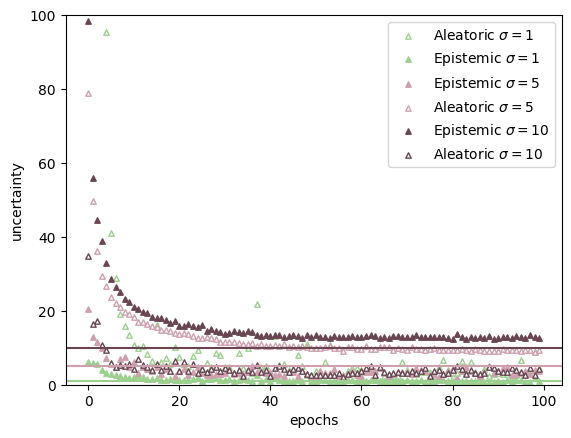

In [24]:
plt.clf()

plt.scatter(range(nepochs), np.sqrt(low_al_var), 
            edgecolor = '#9CD08F',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = 'Aleatoric $\sigma = 1$')

plt.scatter(range(nepochs), low_ep, 
            color = '#9CD08F',
            marker = '^',  
            s = ptsize,
            label = 'Epistemic $\sigma = 1$')
plt.axhline(y = 1,
            color = '#9CD08F')


plt.scatter(range(nepochs), med_ep,
            color = '#CEA0AE',
            marker = '^',  
            s = ptsize,
            label = 'Epistemic $\sigma = 5$')
plt.scatter(range(nepochs), np.sqrt(med_al_var),
            edgecolor = '#CEA0AE',
            color = 'white',
            marker = '^',  
            s = ptsize,
            label = 'Aleatoric $\sigma = 5$')
plt.axhline(y = 5,
            color = '#CEA0AE')
            

#plt.scatter(range(nepochs), high_ep, label = '$\sigma = 10$')

plt.scatter(range(nepochs), np.sqrt(high_al_var),
            color = '#684551',
            marker = '^',
            s = ptsize,
            label = 'Epistemic $\sigma = 10$')

plt.scatter(range(nepochs), high_ep,
            edgecolor = '#684551',
            color = 'white',
            marker = '^',
            s = ptsize,
            label = 'Aleatoric $\sigma = 10$')
plt.axhline(y = 10,
            color = '#684551')


plt.xlabel('epochs')
plt.ylabel('uncertainty')
plt.legend()
plt.ylim([0,100])
plt.show()

This time with errorbars.

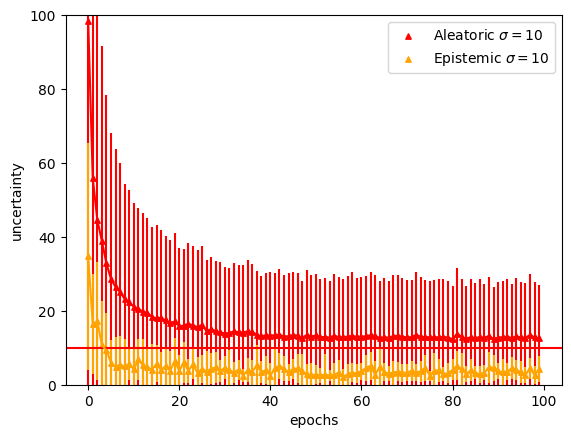

In [25]:
# first just high
plt.clf()
plt.scatter(range(nepochs), np.sqrt(high_al_var),
            color = 'red',
            marker = '^',
            s = ptsize,
            label = 'Aleatoric $\sigma = 10$')
plt.errorbar(range(nepochs), np.sqrt(high_al_var),
             yerr = np.sqrt(high_al_var_std),
             color = 'red',
             marker = None,
             ls = None)
plt.scatter(range(nepochs), high_ep,
            edgecolor = 'orange',
            color = 'orange',
            marker = '^',
            s = ptsize,
            label = 'Epistemic $\sigma = 10$')
plt.errorbar(range(nepochs), high_ep,
             yerr = high_ep_std,
             color = 'orange',
             marker = None,
             ls = None)
plt.axhline(y = 10,
            color = 'red')


plt.xlabel('epochs')
plt.ylabel('uncertainty')
plt.legend()
plt.ylim([0,100])
plt.show()

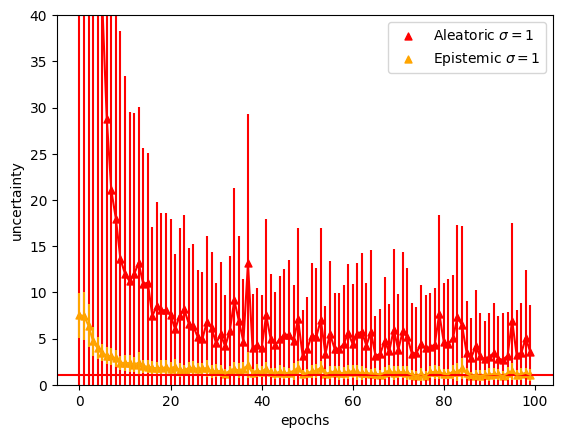

In [35]:
# first just high
plt.clf()
plt.scatter(range(nepochs), np.sqrt(low_al_var),
            color = 'red',
            marker = '^',
            s = ptsize,
            label = 'Aleatoric $\sigma = 1$')
plt.errorbar(range(nepochs), np.sqrt(low_al_var),
             yerr = np.sqrt(low_al_var_std),
             color = 'red',
             marker = None,
             ls = None)
plt.scatter(range(nepochs), low_ep,
            edgecolor = 'orange',
            color = 'orange',
            marker = '^',
            s = ptsize,
            label = 'Epistemic $\sigma = 1$')
plt.errorbar(range(nepochs), low_ep,
             yerr = low_ep_std,
             color = 'orange',
             marker = None,
             ls = None)
plt.axhline(y = 1,
            color = 'red')


plt.xlabel('epochs')
plt.ylabel('uncertainty')
plt.legend()
plt.ylim([0,40])
plt.show()

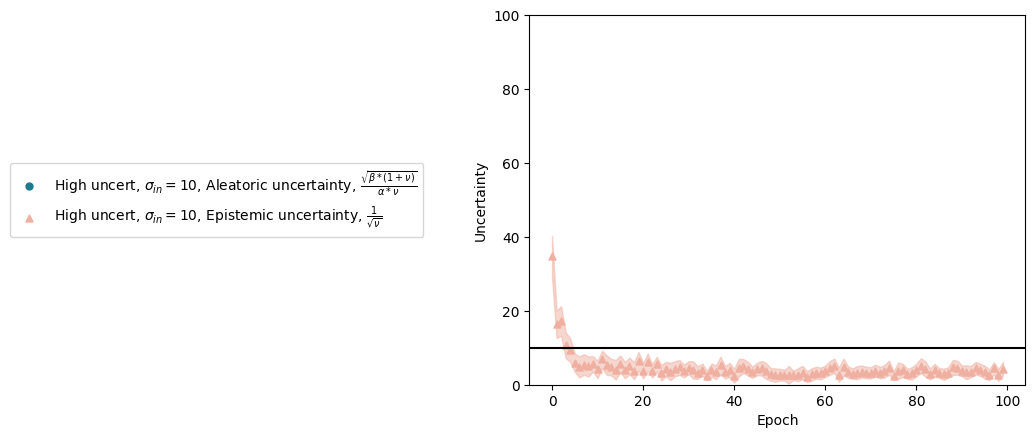

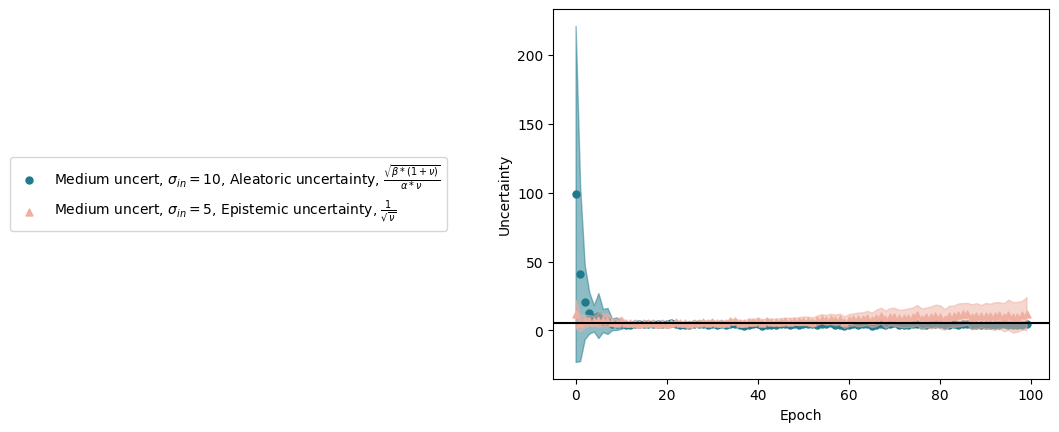

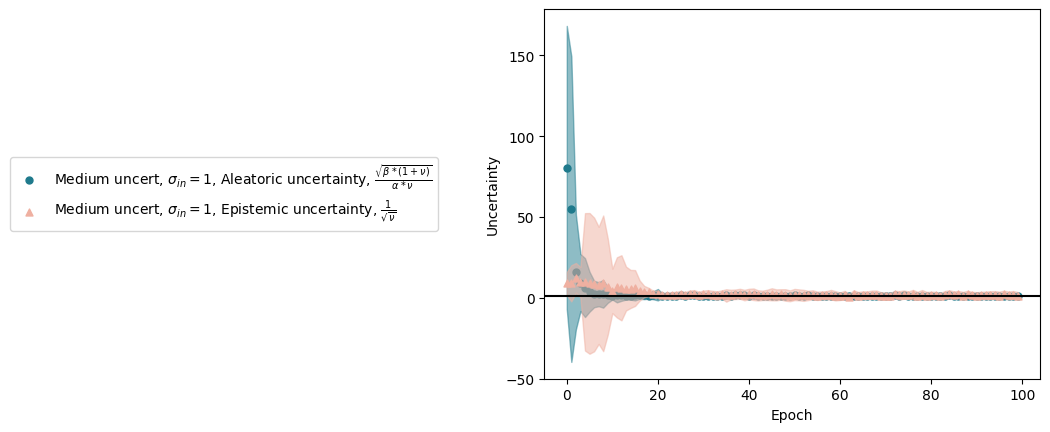

In [27]:
# overplot both
ptsize = 25
plt.clf()
plt.scatter(range(n_epochs), high_al_var,
            color = '#1F7A8C',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plus = np.array(high_al_var) + np.sqrt(np.array(high_al_var_std))
minus = np.array(high_al_var) - np.sqrt(np.array(high_al_var_std))
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#1F7A8C',
                 alpha = 0.5)
plt.scatter(range(n_epochs), high_ep,
            color = '#EFB0A1',
            marker = '^',
            s = ptsize,
            label = r'High uncert, $\sigma_{in} = 10$, Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')
plus = np.array(high_ep) + np.sqrt(np.array(high_ep_std))
minus = np.array(high_ep) - np.sqrt(np.array(high_ep_std))
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#EFB0A1',
                 alpha = 0.5)

plt.axhline(y = 10, color = 'black')
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Uncertainty')
plt.xlabel('Epoch')
plt.ylim([0,100])
plt.show()



plt.clf()
plt.scatter(range(n_epochs), al_medium,
            color = '#1F7A8C',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 10$, Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plus = np.array(al_medium) + np.array(al_std_medium)
minus = np.array(al_medium) - np.array(al_std_medium)
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#1F7A8C',
                 alpha = 0.5)
plt.scatter(range(n_epochs), ep_medium,
            color = '#EFB0A1',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 5$, Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')
plus = np.array(ep_medium) + np.array(ep_std_medium)
minus = np.array(ep_medium) - np.array(ep_std_medium)
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#EFB0A1',
                 alpha = 0.5)

plt.axhline(y = 5, color = 'black')
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Uncertainty')
plt.xlabel('Epoch')
plt.show()

plt.clf()
plt.scatter(range(n_epochs), al_low,
            color = '#1F7A8C',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 1$, Aleatoric uncertainty, $\frac{\sqrt{\beta * (1 + \nu)}}{\alpha * \nu}$')
plus = np.array(al_low) + np.array(al_std_low)
minus = np.array(al_low) - np.array(al_std_low)
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#1F7A8C',
                 alpha = 0.5)
plt.scatter(range(n_epochs), ep_low,
            color = '#EFB0A1',
            marker = '^',
            s = ptsize,
            label = r'Medium uncert, $\sigma_{in} = 1$, Epistemic uncertainty, $\frac{1}{\sqrt{\nu}}$')
plus = np.array(ep_low) + np.array(ep_std_low)
minus = np.array(ep_low) - np.array(ep_std_low)
plt.fill_between(range(n_epochs), 
                 plus,
                 minus, 
                 color = '#EFB0A1',
                 alpha = 0.5)

plt.axhline(y = 1, color = 'black')
plt.legend(loc = 'right', bbox_to_anchor=(-0.2, 0.5))
plt.ylabel('Uncertainty')
plt.xlabel('Epoch')
plt.show()